In [8]:
#!/bin/bash
!curl -L -o libri-noise-dataset.zip https://www.kaggle.com/api/v1/datasets/download/earth16/libri-speech-noise-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 6178M  100 6178M    0     0   151M      0  0:00:40  0:00:40 --:--:--  165M


In [9]:
!unzip -q libri-noise-dataset.zip

In [10]:
!rm -rf BWAVN.7z epoc-27-results.xltx LibriNoise_Train_Test_NPY ModelArchitecture.txt model.h5.png noisesB.7z NoiseTest.pptx NoiseTest_SNR.pptx results.7z

In [11]:
!7z x train.7z -onoisy > /dev/null

In [12]:
!7z x y_train.7z -odenoised > /dev/null

In [13]:
!7z x test.7z -onoisy > /dev/null
!7z x y_test.7z -odenoised > /dev/null

In [14]:
# !pip install complextorch

In [15]:
import librosa
import glob
import matplotlib.pyplot as plt
from IPython.display import Audio, IFrame, display
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm

In [16]:
!ls noisy/train/103-1240-0005.wav

noisy/train/103-1240-0005.wav


In [17]:
!ls denoised/

y_test	y_train


In [18]:
train_noisy_files = sorted(glob.glob('noisy/train/*.wav'))
train_clear_files = sorted(glob.glob('denoised/y_train/*.wav'))
assert len(train_clear_files) == len(train_noisy_files)

In [19]:
train_noisy_files[0], train_clear_files[0]

('noisy/train/103-1240-0005.wav', 'denoised/y_train/103-1240-0005.wav')

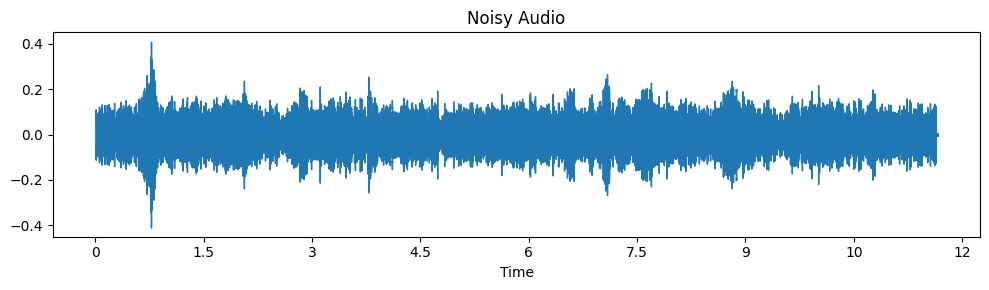

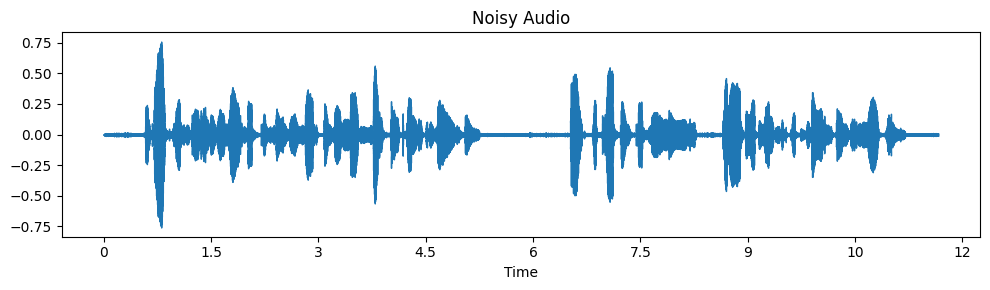

In [20]:
sr = 16000

idx = 1000

x, sr = librosa.load(train_noisy_files[idx], mono=True, sr=sr, offset=0, duration=16)
plt.figure(figsize=(10, 3))
librosa.display.waveshow(x, sr=sr, axis='time')
plt.title("Noisy Audio")
plt.tight_layout()
plt.show()
display(Audio(x,rate=sr))

y, sr = librosa.load(train_clear_files[idx], mono=True, sr=sr, offset=0, duration=16)
plt.figure(figsize=(10, 3))
librosa.display.waveshow(y, sr=sr, axis='time')
plt.title("Noisy Audio")
plt.tight_layout()
plt.show()
display(Audio(y,rate=sr))

In [21]:
import glob
import librosa
import torch
from torch.utils.data import Dataset
import random
import numpy as np
import random

def tensor_to_sftf(arr):
    n_fft = 512
    hop_length = n_fft // 4   # 128
    win_length = n_fft        # 512
    window = torch.hann_window(win_length)

    return torch.stft(arr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, return_complex=True)

class MyDataset(Dataset):
    def __init__(self, noisy_folder='noisy/train/', denoised_folder='denoised/y_train/', ind=None, need_crop=False, cnt_seconds=16, need_all=False, single_file_path=None):
        if (single_file_path is not None):
            self.noisy_files = [single_file_path]
            self.clear_files = [single_file_path]
        else:
            self.noisy_files = np.array(sorted(glob.glob(noisy_folder + '*.wav')))
            self.clear_files = np.array(sorted(glob.glob(denoised_folder + '*.wav')))
        # print(len(self.clear_files))

        assert len(self.noisy_files) == len(self.clear_files)
        for f, s in zip(self.noisy_files, self.clear_files):
            assert f.split('/')[-1] == s.split('/')[-1]

        if ind is not None:
            self.noisy_files = self.noisy_files[ind]
            self.clear_files = self.clear_files[ind]
        self.cnt_seconds = cnt_seconds
        self.sr = 16000
        self.need_crop = need_crop
        self.need_all = need_all
            
    def __len__(self):
        return len(self.noisy_files)

    def __getitem__(self, idx):
        need_size = self.cnt_seconds * self.sr
        
        noisy_file = self.noisy_files[idx]
        clear_file = self.clear_files[idx]

        noisy_arr, _ = librosa.load(noisy_file, mono=True, sr=self.sr, offset=0)
        clear_arr, _ = librosa.load(clear_file, mono=True, sr=self.sr, offset=0)

        noisy_arr = torch.tensor(noisy_arr, dtype=torch.float)
        clear_arr = torch.tensor(clear_arr, dtype=torch.float)

        if self.need_all:
            noisy_segments = []
            clear_segments = []

            num_segments = max(len(noisy_arr) // need_size, 1)
            for i in range(num_segments):
                start = i * need_size
                noisy_segments.append(noisy_arr[start:start + need_size])
                clear_segments.append(clear_arr[start:start + need_size])

            noisy_segments = [seg if seg.shape[0] == need_size else torch.cat((seg, torch.zeros(need_size - seg.shape[0]))) for seg in noisy_segments]
            clear_segments = [seg if seg.shape[0] == need_size else torch.cat((seg, torch.zeros(need_size - seg.shape[0]))) for seg in clear_segments]

            # noisy_segments = []
            noisy_segments = [tensor_to_sftf(cur) for cur in noisy_segments]
            # clear_segments = [tensor_to_sftf(cur) for cur in clear_segments]
            
            return (torch.stack(noisy_segments).unsqueeze(1), torch.stack(clear_segments).unsqueeze(1))

        if not self.need_crop:
            noisy_arr = torch.cat((noisy_arr[:need_size], torch.zeros(need_size - noisy_arr.shape[0])))
            clear_arr = torch.cat((clear_arr[:need_size], torch.zeros(need_size - clear_arr.shape[0])))
        else:
            l = random.randint(0, max(1, noisy_arr.shape[0] - need_size))
            r = min(l + need_size, noisy_arr.shape[0])
            noisy_arr = noisy_arr[l:r]
            clear_arr = clear_arr[l:r]
            noisy_arr = torch.cat((noisy_arr[:need_size], torch.zeros(need_size - noisy_arr.shape[0])))
            clear_arr = torch.cat((clear_arr[:need_size], torch.zeros(need_size - clear_arr.shape[0])))

        assert noisy_arr.shape == clear_arr.shape

        # print(noisy_arr.shape)
        # noisy_stft = torch.tensor(librosa.stft(noisy_arr.numpy())).unsqueeze(0)
        # clear_stft = torch.tensor(librosa.stft(clear_arr.numpy())).unsqueeze(0)
        noisy_stft = tensor_to_sftf(noisy_arr).unsqueeze(0)
        # clear_stft = tensor_to_sftf(clear_arr).unsqueeze(0)
        clear_arr = clear_arr.unsqueeze(0)

        return (noisy_stft, clear_arr)


In [22]:

n_total = 7000
cnt_valid = 400
all_indices = list(range(n_total))

random.seed(42)
random.shuffle(all_indices)
valid_indices = np.array(all_indices[:cnt_valid])
train_indices = np.array(all_indices[cnt_valid:])

train_dataset = MyDataset(noisy_folder='noisy/train/', denoised_folder='denoised/y_train/', need_crop=True, cnt_seconds=4, need_all=False, ind=train_indices)
valid_dataset = MyDataset(noisy_folder='noisy/train/', denoised_folder='denoised/y_train/', need_crop=True, cnt_seconds=4, need_all=True, ind=valid_indices)
test_dataset = MyDataset(noisy_folder='noisy/test/',  denoised_folder='denoised/y_test/', need_crop=True, cnt_seconds=4, need_all=True)

# train_dataset = MyDataset(noisy_folder='noisy/train/', denoised_folder='denoised/y_train/', need_crop=True, cnt_seconds=2, need_all=False, ind=train_indices)
# valid_dataset = MyDataset(noisy_folder='noisy/train/', denoised_folder='denoised/y_train/', need_crop=True, cnt_seconds=2, need_all=True, ind=valid_indices)
# test_dataset = MyDataset(noisy_folder='noisy/test/',  denoised_folder='denoised/y_test/', need_crop=True, cnt_seconds=2, need_all=True)

In [23]:
len(train_dataset), len(valid_dataset), len(test_dataset)

(6600, 400, 105)

In [24]:
# train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [25]:
train_dataset[0][0].shape, train_dataset[0][1].shape

(torch.Size([1, 257, 501]), torch.Size([1, 64000]))

In [26]:
def pad_or_trim_2d(x, ref):
    """
    Make x’s spatial dims match ref’s spatial dims by
    zero‑padding or trimming on the right/bottom.
    x: [B, C, Hx, Wx]
    ref: [B, C_ref, Hr, Wr]
    Returns: x’ of shape [B, C, Hr, Wr]
    """
    Hr, Wr = ref.size(2), ref.size(3)
    Hx, Wx = x.size(2),   x.size(3)

    # pad/trim height
    dh = Hr - Hx
    if dh > 0:
        x = F.pad(x, (0, 0, 0, dh))
    elif dh < 0:
        x = x[:, :, :Hr, :]

    dw = Wr - x.size(3)
    if dw > 0:
        x = F.pad(x, (0, dw, 0, 0))
    elif dw < 0:
        # trim right
        x = x[:, :, :, :Wr]

    return x


class UModel(nn.Module):
    def make_ds_conv_block(self, idx):
        in_channels = (1 if idx == 1 else self.F_c*(idx-1))
        padd = (self.f_d//2 if isinstance(self.f_d, int) else [self.f_d[0] // 2, self.f_d[1] // 2])
        out_channels = self.F_c * idx
        return [
                    nn.Conv2d(in_channels, out_channels, kernel_size=self.f_d, padding=padd),
                    nn.Conv2d(in_channels, out_channels, kernel_size=self.f_d, padding=padd),
                    nn.BatchNorm2d(out_channels),
                    nn.BatchNorm2d(out_channels),
                    nn.AvgPool2d(kernel_size=2),
                    nn.PReLU(),
                ]

    def make_us_conv_block(self, idx):
        in_channels = self.F_c * idx * 2
        out_channels = (self.k if idx == 1 else self.F_c * (idx - 1))
        if (idx > 1):
            return [
                        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=self.f_u, padding=self.f_u//2, stride=2),
                        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=self.f_u, padding=self.f_u//2, stride=2),
                        nn.BatchNorm2d(out_channels),
                        nn.BatchNorm2d(out_channels),
                        nn.PReLU(),
                   ]
        else:
            return [
                        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=self.f_u, padding=self.f_u//2, stride=2),
                        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=self.f_u, padding=self.f_u//2, stride=2),
                        nn.BatchNorm2d(out_channels),
                        nn.BatchNorm2d(out_channels),
                        nn.Tanh(),
                   ]

    def apply_complex_conv(self, X_r, X_i, conv_r, conv_i):
        y_r = conv_r(X_r) - conv_i(X_i)
        y_i = conv_i(X_r) + conv_r(X_i)
        return y_r, y_i

    def apply_complex_norm(self, X_r, X_i, norm_r, norm_i):
        y_r = norm_r(X_r)
        y_i = norm_i(X_i)
        return y_r, y_i
    
    def apply_complex_func(self, X_r, X_i, func):
        y_r = func(X_r)
        y_i = func(X_i)
        return y_r, y_i
    
    def apply_ds_block(self, X_r, X_i, block):
        X_r, X_i = self.apply_complex_conv(X_r, X_i, block[0], block[1])
        X_r, X_i = self.apply_complex_norm(X_r, X_i, block[2], block[3])
        X_r, X_i = self.apply_complex_func(X_r, X_i, block[4])
        X_r, X_i = self.apply_complex_func(X_r, X_i, block[5])
        return X_r, X_i

    def apply_us_block(self, X_r, X_i, block):
        X_r, X_i = self.apply_complex_conv(X_r, X_i, block[0], block[1])
        X_r, X_i = self.apply_complex_norm(X_r, X_i, block[2], block[3])
        X_r, X_i = self.apply_complex_func(X_r, X_i, block[4])
        # X = self.apply_complex_func(X, block[5])
        return X_r, X_i
        
    def __init__(self, L, F_c, f_d, f_u, k):
        super().__init__()
        self.L = L
        self.F_c = F_c
        self.f_d = f_d
        self.f_u = f_u
        self.k = k
        
        self.ds_conv_blocks = []
        for i in range(1, L + 1):
            self.ds_conv_blocks.append(nn.ModuleList(self.make_ds_conv_block(i)))

        self.back_bone = nn.ModuleList([
            nn.GRU(input_size=288, hidden_size=288,num_layers=2, batch_first=True),
            nn.GRU(input_size=288, hidden_size=288,num_layers=2, batch_first=True)
        ]) ## bidirectional??
        self.us_conv_blocks = [None] * L
        for i in range(1, L + 1, 1):
             self.us_conv_blocks[i - 1] = nn.ModuleList(self.make_us_conv_block(i))

        self.ds_conv_blocks = nn.ModuleList(self.ds_conv_blocks)
        self.us_conv_blocks = nn.ModuleList(self.us_conv_blocks)

    def apply_complex_lstm(self, X_r, X_i, lstm_r, lstm_i):
        y_r = lstm_r(X_r)[0] - lstm_i(X_i)[0]
        y_i = lstm_r(X_i)[0] + lstm_i(X_r)[0]
        return y_r, y_i

    def forward(self, X_r, X_i):
        
        ds_tensors = []
        ds_tensors.append((X_r, X_i))
        for i in range(1, self.L + 1):
            X_r, X_i = self.apply_ds_block(X_r, X_i, self.ds_conv_blocks[i - 1])
            ds_tensors.append((X_r, X_i))

        assert X_r.shape == X_i.shape
        # B x C x H x W
        
        # print(X_r.shape, X_i.shape)
        h, w = X_r.shape[2], X_r.shape[3]
        X_r = X_r.reshape(X_r.shape[0], X_r.shape[1], -1).permute(0, 2, 1)
        X_i = X_i.reshape(X_i.shape[0], X_i.shape[1], -1).permute(0, 2, 1)
        # B x H*W x C
        X_r,X_i = self.apply_complex_lstm(X_r, X_i, self.back_bone[0], self.back_bone[1])
        # print(X_r.shape, X_i.shape)
        X_r = X_r.permute(0, 2, 1)
        X_i = X_i.permute(0, 2, 1)
        # print(X_r.shape, X_i.shape)
        X_r = X_r.reshape(X_r.shape[0], X_r.shape[1], h, w)
        X_i = X_i.reshape(X_i.shape[0], X_i.shape[1], h, w)
        
        # B x C x H x W
        # C = L * F_c

        for i in range(self.L, 0, -1):
            skip_r, skip_i = ds_tensors[i]
            
            X_r = pad_or_trim_2d(X_r, skip_r)
            X_i = pad_or_trim_2d(X_i, skip_i)
            # print(X_r.shape, skip_r.shape)
            
            # del skip
            # break                 
            new_X_r = torch.concat((X_r, skip_r), dim=1)
            new_X_i = torch.concat((X_i, skip_i), dim=1)
            X_r,X_i = self.apply_us_block(new_X_r, new_X_i, self.us_conv_blocks[i - 1])

        # print(X.shape, ds_tensors[0].shape)
        X_r = pad_or_trim_2d(X_r, ds_tensors[0][0])
        X_i = pad_or_trim_2d(X_i, ds_tensors[0][1])
        return X_r, X_i

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UModel(L=6, F_c=48, f_d=[13, 2], f_u=5, k=1).to(device)
model = nn.DataParallel(model, device_ids=['cuda:0', 'cuda:1'], output_device=0) # cant parralel??
# because of complex numbers, need to move complex to 2 channels

In [27]:
for cur,_ in train_dataloader:
    cur = cur.to(device)
    print(cur.shape, cur.dtype)
    # cur = cur.unsqueeze(0)
    cur_ans_r, cur_ans_i = model(cur.real, cur.imag)
    cur_ans = torch.complex(cur_ans_r, cur_ans_i)
    print(cur_ans.shape)
    del cur_ans
    del cur_ans_r
    del cur_ans_i
    break

torch.Size([32, 1, 257, 501]) torch.complex64
torch.Size([32, 1, 257, 501])


In [28]:
!pip install asteroid

In [29]:
!pip install pesq

In [30]:
from torchmetrics.audio import ScaleInvariantSignalDistortionRatio
from pesq import pesq

In [31]:
from torchmetrics.audio import PerceptualEvaluationSpeechQuality

In [32]:
def calculate_batch_SI_SDR(preds_batch, y_batch, SI_SDR_metric):
    sum_metric = 0
    for cur_pred, cur_y in zip(preds_batch, y_batch):
        try:
            cur = SI_SDR_metric(cur_pred, cur_y)
            sum_metric += cur
        except:
            continue
    return sum_metric / len(preds_batch)

def calculate_batch_PESQ(preds_batch, y_batch, fs=16000, mode='wb'):
    total, count = 0.0, 0
    for cur_pred, cur_y in zip(preds_batch, y_batch):
        ref = cur_y.squeeze(0).detach().cpu().numpy()
        deg = cur_pred.squeeze(0).detach().cpu().numpy()

        try:
            score = pesq(fs, ref=ref, deg=deg, mode=mode)
            total += score
            count += 1
        except:
            continue

    return total / count if count > 0 else 0.0

In [33]:
from torchmetrics.audio import ScaleInvariantSignalDistortionRatio

def from_sftf(X_r, X_i):
    # [B x 1 x H x W] -> [B x H x W]
    X_r = X_r.reshape(X_r.shape[0], X_r.shape[2], X_r.shape[3])
    X_i = X_i.reshape(X_i.shape[0], X_i.shape[2], X_i.shape[3])
    complex_spec = torch.complex(X_r, X_i)

    n_fft = 512
    hop_length = n_fft // 4   # 128
    win_length = n_fft        # 512
    window = torch.hann_window(win_length)
    
    wave = torch.istft(
        complex_spec,
        n_fft=n_fft,            # тот же N, что в stft
        hop_length=hop_length,
        win_length=win_length,
        window=window.to(device),
        center=True,
    )
    return wave.unsqueeze(1)

def train(model, criterion, train_dataloader, valid_dataset, optimizer, epochs, device, metrics):
    best_sdr = -1e6
    best_loss = 1e6

    SI_SDR_metric = ScaleInvariantSignalDistortionRatio(
        zero_mean=True, 
    ).to(device)
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0        

        cnt_steps_train = len(train_dataloader)
        for batch_x, batch_y in tqdm(train_dataloader):

            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            preds_r, preds_i = model(batch_x.real, batch_x.imag)
            preds = from_sftf(preds_r, preds_i)
            # print(preds.shape, real_ans.shape)

            # print(preds.shape, batch_y.shape)
            loss = criterion(preds, batch_y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            with torch.no_grad():
                train_loss += loss.item()


        train_loss /= cnt_steps_train
        print(f'Epoch {epoch}/{epochs} | Train Loss: {train_loss:.6f}')

        metrics['train_loss'].append(train_loss)
        
        model.eval()
        valid_loss = 0
        valid_sdr = 0
        # valid_pesq = 0
        with torch.no_grad():
            for batch_x, batch_y in tqdm(valid_dataset):
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                # print(batch_x.shape, batch_y.shape)
                
                preds_r, preds_i = model(batch_x.real, batch_x.imag)
                preds = from_sftf(preds_r, preds_i)
                # real_ans = from_sftf(batch_y.real, batch_y.imag)

                
                loss = criterion(preds, batch_y)
                valid_loss += loss.item()
                
                valid_sdr += SI_SDR_metric(preds, batch_y)
                
                # valid_pesq += calculate_batch_PESQ(preds, batch_y)
                
        valid_loss /= len(valid_dataset)
        valid_sdr /= len(valid_dataset)
        # valid_pesq /= len(valid_dataset)
        

        print(f'Epoch {epoch}/{epochs} | Valid Loss: {valid_loss:.6f} | Valid SI-SDR: {valid_sdr:.4f}')
        
        metrics['valid_loss'].append(valid_loss)
        metrics['valid_si_sdr'].append(valid_sdr)
        # metrics['valid_pesq'].append(valid_pesq)

        if valid_sdr > best_sdr:
            best_sdr = valid_sdr
            sdr_model = model
        if valid_loss < best_loss:
            best_loss = valid_loss
            loss_model = model
            
    return sdr_model, loss_model

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = UModel(L=12, F_c=24, f_d=15, f_u=5, k=1).to(device)
model = UModel(L=6, F_c=48, f_d=[13, 2], f_u=5, k=1).to(device)

model = nn.DataParallel(model, device_ids=['cuda:0', 'cuda:1'])
# criterion = nn.MSELoss()

metrics = {
    'train_loss': [],
    'train_si_sdr': [],
    'train_pesq': [],
    'valid_loss': [],
    'valid_si_sdr': [],
    'valid_pesq': []
}


In [29]:
# from asteroid.losses import SingleSrcPMSQE

In [30]:
def si_sdr_loss(pred, ref, eps=1e-8):
    # pred/ref shape: [B, 1, T]
    ref_energy = torch.sum(ref**2, dim=-1, keepdim=True) + eps
    proj = torch.sum(pred * ref, dim=-1, keepdim=True) * ref / ref_energy
    
    noise = pred - proj

    num = torch.sum(proj**2, dim=-1)
    den = torch.sum(noise**2, dim=-1)
    ratio = num / (den + eps)
    ratio = torch.clamp(ratio, min=eps)
    sisd = 10 * torch.log10(ratio)
    return -sisd.mean()


# class SI_SDR_PESQ_Loss(nn.Module):
#     def __init__(self, alpha):
#         super().__init__()
#         self.alpha = alpha
#         self.pmsqe = SingleSrcPMSQE(sample_rate=16000).to(device)
#         self.si_sdr_loss = si_sdr_loss
        
#         self.n_fft = 512
#         self.win_length = 512
#         self.hop_length = 128
#         self.window = torch.hann_window(self.win_length)

#     def forward(self, preds, target):
#         sdr_loss = self.si_sdr_loss(preds, target)

#         preds1 = preds.squeeze(1) 
#         target1 = target.squeeze(1)

#         window = self.window.to(preds1.device)

#         def mag_stft(x):
#             stft = torch.stft(x, n_fft=self.n_fft, hop_length=self.hop_length,
#                               win_length=self.win_length, window=window,
#                               return_complex=True)
#             return torch.abs(stft) 

#         preds_mag = mag_stft(preds1)
#         target_mag = mag_stft(target1)

#         pmsqe_loss = self.pmsqe(preds_mag, target_mag).mean()
#         return sdr_loss + self.alpha * pmsqe_loss


criterion = si_sdr_loss

In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [32]:
best_sdr, best_loss = train(model, criterion, train_dataloader, valid_dataset, optimizer, 20, device, metrics)

100%|██████████| 207/207 [07:56<00:00,  2.30s/it]


Epoch 1/20 | Train Loss: 4.506898


100%|██████████| 400/400 [00:38<00:00, 10.28it/s]


Epoch 1/20 | Valid Loss: 0.347178 | Valid SI-SDR: -0.3301


100%|██████████| 207/207 [08:10<00:00,  2.37s/it]


Epoch 2/20 | Train Loss: -0.390806


100%|██████████| 400/400 [00:38<00:00, 10.29it/s]


Epoch 2/20 | Valid Loss: -0.292994 | Valid SI-SDR: 0.2837


100%|██████████| 207/207 [08:09<00:00,  2.37s/it]


Epoch 3/20 | Train Loss: -1.955601


100%|██████████| 400/400 [00:38<00:00, 10.27it/s]


Epoch 3/20 | Valid Loss: -1.673620 | Valid SI-SDR: 1.6563


100%|██████████| 207/207 [08:09<00:00,  2.36s/it]


Epoch 4/20 | Train Loss: -3.174688


100%|██████████| 400/400 [00:38<00:00, 10.30it/s]


Epoch 4/20 | Valid Loss: -3.778801 | Valid SI-SDR: 3.7971


100%|██████████| 207/207 [08:09<00:00,  2.36s/it]


Epoch 5/20 | Train Loss: -4.084328


100%|██████████| 400/400 [00:38<00:00, 10.30it/s]


Epoch 5/20 | Valid Loss: -3.760190 | Valid SI-SDR: 3.7459


100%|██████████| 207/207 [08:09<00:00,  2.36s/it]


Epoch 6/20 | Train Loss: -4.981088


100%|██████████| 400/400 [00:38<00:00, 10.27it/s]


Epoch 6/20 | Valid Loss: -3.293728 | Valid SI-SDR: 3.2784


100%|██████████| 207/207 [08:09<00:00,  2.36s/it]


Epoch 7/20 | Train Loss: -5.725092


100%|██████████| 400/400 [00:38<00:00, 10.32it/s]


Epoch 7/20 | Valid Loss: -4.241039 | Valid SI-SDR: 4.2652


100%|██████████| 207/207 [08:09<00:00,  2.37s/it]


Epoch 8/20 | Train Loss: -6.321217


100%|██████████| 400/400 [00:38<00:00, 10.31it/s]


Epoch 8/20 | Valid Loss: -3.419661 | Valid SI-SDR: 3.4650


100%|██████████| 207/207 [08:09<00:00,  2.36s/it]


Epoch 9/20 | Train Loss: -6.790598


100%|██████████| 400/400 [00:38<00:00, 10.31it/s]


Epoch 9/20 | Valid Loss: -6.603765 | Valid SI-SDR: 6.6079


100%|██████████| 207/207 [08:09<00:00,  2.36s/it]


Epoch 10/20 | Train Loss: -7.189033


100%|██████████| 400/400 [00:38<00:00, 10.32it/s]


Epoch 10/20 | Valid Loss: -7.230055 | Valid SI-SDR: 7.2151


100%|██████████| 207/207 [08:09<00:00,  2.36s/it]


Epoch 11/20 | Train Loss: -7.425418


100%|██████████| 400/400 [00:38<00:00, 10.30it/s]


Epoch 11/20 | Valid Loss: -7.496674 | Valid SI-SDR: 7.4744


100%|██████████| 207/207 [08:13<00:00,  2.38s/it]


Epoch 12/20 | Train Loss: -7.378947


100%|██████████| 400/400 [00:39<00:00, 10.00it/s]


Epoch 12/20 | Valid Loss: -4.831823 | Valid SI-SDR: 4.8915


100%|██████████| 207/207 [08:27<00:00,  2.45s/it]


Epoch 13/20 | Train Loss: -7.764622


100%|██████████| 400/400 [00:40<00:00,  9.97it/s]


Epoch 13/20 | Valid Loss: -2.874576 | Valid SI-SDR: 2.9538


100%|██████████| 207/207 [08:27<00:00,  2.45s/it]


Epoch 14/20 | Train Loss: -7.959694


100%|██████████| 400/400 [00:40<00:00,  9.85it/s]


Epoch 14/20 | Valid Loss: -2.754620 | Valid SI-SDR: 2.8547


100%|██████████| 207/207 [08:26<00:00,  2.45s/it]


Epoch 15/20 | Train Loss: -8.265129


100%|██████████| 400/400 [00:40<00:00,  9.82it/s]


Epoch 15/20 | Valid Loss: -7.366824 | Valid SI-SDR: 7.3509


100%|██████████| 207/207 [08:28<00:00,  2.46s/it]


Epoch 16/20 | Train Loss: -8.419952


100%|██████████| 400/400 [00:40<00:00,  9.83it/s]


Epoch 16/20 | Valid Loss: -5.675657 | Valid SI-SDR: 5.7198


100%|██████████| 207/207 [08:26<00:00,  2.45s/it]


Epoch 17/20 | Train Loss: -8.642263


100%|██████████| 400/400 [00:40<00:00,  9.85it/s]


Epoch 17/20 | Valid Loss: -8.372728 | Valid SI-SDR: 8.3388


100%|██████████| 207/207 [08:27<00:00,  2.45s/it]


Epoch 18/20 | Train Loss: -8.686438


100%|██████████| 400/400 [00:40<00:00,  9.79it/s]


Epoch 18/20 | Valid Loss: -7.484002 | Valid SI-SDR: 7.4850


100%|██████████| 207/207 [08:28<00:00,  2.45s/it]


Epoch 19/20 | Train Loss: -8.828469


100%|██████████| 400/400 [00:41<00:00,  9.72it/s]


Epoch 19/20 | Valid Loss: -8.462184 | Valid SI-SDR: 8.4458


100%|██████████| 207/207 [08:28<00:00,  2.46s/it]


Epoch 20/20 | Train Loss: -8.961410


100%|██████████| 400/400 [00:40<00:00,  9.80it/s]

Epoch 20/20 | Valid Loss: -5.717219 | Valid SI-SDR: 5.7798


In [33]:
model = best_loss

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
best_sdr, best_loss = train(model, criterion, train_dataloader, valid_dataset, optimizer, 20, device, metrics)

100%|██████████| 207/207 [08:28<00:00,  2.46s/it]


Epoch 1/20 | Train Loss: -8.882495


100%|██████████| 400/400 [00:40<00:00,  9.80it/s]


Epoch 1/20 | Valid Loss: -9.201572 | Valid SI-SDR: 9.1626


100%|██████████| 207/207 [08:26<00:00,  2.45s/it]


Epoch 2/20 | Train Loss: -9.173184


100%|██████████| 400/400 [00:40<00:00,  9.78it/s]


Epoch 2/20 | Valid Loss: -8.777306 | Valid SI-SDR: 8.7392


100%|██████████| 207/207 [08:27<00:00,  2.45s/it]


Epoch 3/20 | Train Loss: -9.337373


100%|██████████| 400/400 [00:40<00:00,  9.82it/s]


Epoch 3/20 | Valid Loss: -9.145071 | Valid SI-SDR: 9.1052


100%|██████████| 207/207 [08:28<00:00,  2.46s/it]


Epoch 4/20 | Train Loss: -9.479822


100%|██████████| 400/400 [00:40<00:00,  9.79it/s]


Epoch 4/20 | Valid Loss: -9.442268 | Valid SI-SDR: 9.3961


100%|██████████| 207/207 [08:27<00:00,  2.45s/it]


Epoch 5/20 | Train Loss: -9.558123


100%|██████████| 400/400 [00:40<00:00,  9.85it/s]


Epoch 5/20 | Valid Loss: -7.420022 | Valid SI-SDR: 7.5093


100%|██████████| 207/207 [08:27<00:00,  2.45s/it]


Epoch 6/20 | Train Loss: -9.674547


100%|██████████| 400/400 [00:40<00:00,  9.83it/s]


Epoch 6/20 | Valid Loss: -9.794376 | Valid SI-SDR: 9.7496


100%|██████████| 207/207 [08:27<00:00,  2.45s/it]


Epoch 7/20 | Train Loss: -9.748957


100%|██████████| 400/400 [00:40<00:00,  9.82it/s]


Epoch 7/20 | Valid Loss: -9.831655 | Valid SI-SDR: 9.8037


100%|██████████| 207/207 [08:27<00:00,  2.45s/it]


Epoch 8/20 | Train Loss: -9.835666


100%|██████████| 400/400 [00:40<00:00,  9.83it/s]


Epoch 8/20 | Valid Loss: -6.973823 | Valid SI-SDR: 7.0401


100%|██████████| 207/207 [08:27<00:00,  2.45s/it]


Epoch 9/20 | Train Loss: -9.917914


100%|██████████| 400/400 [00:40<00:00,  9.83it/s]


Epoch 9/20 | Valid Loss: -9.213879 | Valid SI-SDR: 9.1801


100%|██████████| 207/207 [08:26<00:00,  2.45s/it]


Epoch 10/20 | Train Loss: -9.828568


100%|██████████| 400/400 [00:40<00:00,  9.81it/s]


Epoch 10/20 | Valid Loss: -6.687727 | Valid SI-SDR: 6.8152


100%|██████████| 207/207 [08:27<00:00,  2.45s/it]


Epoch 11/20 | Train Loss: -10.025258


100%|██████████| 400/400 [00:40<00:00,  9.77it/s]


Epoch 11/20 | Valid Loss: -9.681952 | Valid SI-SDR: 9.6341


100%|██████████| 207/207 [08:24<00:00,  2.44s/it]


Epoch 12/20 | Train Loss: -10.090986


100%|██████████| 400/400 [00:39<00:00, 10.21it/s]


Epoch 12/20 | Valid Loss: -9.993853 | Valid SI-SDR: 9.9588


100%|██████████| 207/207 [08:09<00:00,  2.36s/it]


Epoch 13/20 | Train Loss: -10.156201


100%|██████████| 400/400 [00:38<00:00, 10.29it/s]


Epoch 13/20 | Valid Loss: -10.219468 | Valid SI-SDR: 10.1702


100%|██████████| 207/207 [08:09<00:00,  2.37s/it]


Epoch 14/20 | Train Loss: -10.214014


100%|██████████| 400/400 [00:38<00:00, 10.28it/s]


Epoch 14/20 | Valid Loss: -3.048165 | Valid SI-SDR: 3.1862


100%|██████████| 207/207 [08:09<00:00,  2.36s/it]


Epoch 15/20 | Train Loss: -10.272081


100%|██████████| 400/400 [00:38<00:00, 10.29it/s]


Epoch 15/20 | Valid Loss: -10.259091 | Valid SI-SDR: 10.2178


100%|██████████| 207/207 [08:26<00:00,  2.45s/it]


Epoch 16/20 | Train Loss: -10.308549


100%|██████████| 400/400 [00:40<00:00,  9.88it/s]


Epoch 16/20 | Valid Loss: -10.024859 | Valid SI-SDR: 9.9795


100%|██████████| 207/207 [08:26<00:00,  2.45s/it]


Epoch 17/20 | Train Loss: -10.384131


100%|██████████| 400/400 [00:40<00:00,  9.81it/s]


Epoch 17/20 | Valid Loss: -7.135565 | Valid SI-SDR: 7.2247


100%|██████████| 207/207 [08:27<00:00,  2.45s/it]


Epoch 18/20 | Train Loss: -10.398125


100%|██████████| 400/400 [00:40<00:00,  9.87it/s]


Epoch 18/20 | Valid Loss: -10.265044 | Valid SI-SDR: 10.2228


100%|██████████| 207/207 [08:26<00:00,  2.45s/it]


Epoch 19/20 | Train Loss: -10.441829


100%|██████████| 400/400 [00:40<00:00,  9.83it/s]


Epoch 19/20 | Valid Loss: -10.338977 | Valid SI-SDR: 10.2935


100%|██████████| 207/207 [08:27<00:00,  2.45s/it]


Epoch 20/20 | Train Loss: -10.503924


100%|██████████| 400/400 [00:40<00:00,  9.82it/s]

Epoch 20/20 | Valid Loss: -10.511831 | Valid SI-SDR: 10.4640


In [35]:
model = best_loss

In [36]:
# criterion = SI_SDR_PESQ_Loss(0.6)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
best_sdr, best_loss = train(model, criterion, train_dataloader, valid_dataset, optimizer, 15, device, metrics)

100%|██████████| 207/207 [08:28<00:00,  2.46s/it]


Epoch 1/15 | Train Loss: -10.693028


100%|██████████| 400/400 [00:40<00:00,  9.81it/s]


Epoch 1/15 | Valid Loss: -10.351143 | Valid SI-SDR: 10.3077


100%|██████████| 207/207 [08:27<00:00,  2.45s/it]


Epoch 2/15 | Train Loss: -10.785374


100%|██████████| 400/400 [00:40<00:00,  9.84it/s]


Epoch 2/15 | Valid Loss: -10.606965 | Valid SI-SDR: 10.5605


100%|██████████| 207/207 [08:27<00:00,  2.45s/it]


Epoch 3/15 | Train Loss: -10.814121


100%|██████████| 400/400 [00:40<00:00,  9.84it/s]


Epoch 3/15 | Valid Loss: -10.354917 | Valid SI-SDR: 10.3103


100%|██████████| 207/207 [08:27<00:00,  2.45s/it]


Epoch 4/15 | Train Loss: -10.842008


100%|██████████| 400/400 [00:40<00:00,  9.84it/s]


Epoch 4/15 | Valid Loss: -10.552184 | Valid SI-SDR: 10.5096


100%|██████████| 207/207 [08:27<00:00,  2.45s/it]


Epoch 5/15 | Train Loss: -10.883776


100%|██████████| 400/400 [00:40<00:00,  9.83it/s]


Epoch 5/15 | Valid Loss: -10.853167 | Valid SI-SDR: 10.8046


100%|██████████| 207/207 [08:27<00:00,  2.45s/it]


Epoch 6/15 | Train Loss: -10.865336


100%|██████████| 400/400 [00:40<00:00,  9.82it/s]


Epoch 6/15 | Valid Loss: -10.986090 | Valid SI-SDR: 10.9359


100%|██████████| 207/207 [08:27<00:00,  2.45s/it]


Epoch 7/15 | Train Loss: -10.877503


100%|██████████| 400/400 [00:40<00:00,  9.76it/s]


Epoch 7/15 | Valid Loss: -10.857200 | Valid SI-SDR: 10.8133


100%|██████████| 207/207 [08:27<00:00,  2.45s/it]


Epoch 8/15 | Train Loss: -10.916044


100%|██████████| 400/400 [00:40<00:00,  9.82it/s]


Epoch 8/15 | Valid Loss: -10.776188 | Valid SI-SDR: 10.7264


100%|██████████| 207/207 [08:26<00:00,  2.45s/it]


Epoch 9/15 | Train Loss: -10.871148


100%|██████████| 400/400 [00:40<00:00,  9.82it/s]


Epoch 9/15 | Valid Loss: -10.921072 | Valid SI-SDR: 10.8732


100%|██████████| 207/207 [08:26<00:00,  2.45s/it]


Epoch 10/15 | Train Loss: -10.968567


100%|██████████| 400/400 [00:40<00:00,  9.84it/s]


Epoch 10/15 | Valid Loss: -10.935205 | Valid SI-SDR: 10.8856


100%|██████████| 207/207 [08:27<00:00,  2.45s/it]


Epoch 11/15 | Train Loss: -10.978096


100%|██████████| 400/400 [00:40<00:00,  9.91it/s]


Epoch 11/15 | Valid Loss: -11.005255 | Valid SI-SDR: 10.9627


100%|██████████| 207/207 [08:27<00:00,  2.45s/it]


Epoch 12/15 | Train Loss: -11.018598


100%|██████████| 400/400 [00:40<00:00,  9.92it/s]


Epoch 12/15 | Valid Loss: -11.079474 | Valid SI-SDR: 11.0299


100%|██████████| 207/207 [08:27<00:00,  2.45s/it]


Epoch 13/15 | Train Loss: -11.033906


100%|██████████| 400/400 [00:40<00:00,  9.81it/s]


Epoch 13/15 | Valid Loss: -11.102536 | Valid SI-SDR: 11.0547


100%|██████████| 207/207 [08:27<00:00,  2.45s/it]


Epoch 14/15 | Train Loss: -11.033718


100%|██████████| 400/400 [00:40<00:00,  9.87it/s]


Epoch 14/15 | Valid Loss: -11.138388 | Valid SI-SDR: 11.0884


100%|██████████| 207/207 [08:28<00:00,  2.45s/it]


Epoch 15/15 | Train Loss: -11.058472


100%|██████████| 400/400 [00:40<00:00,  9.80it/s]

Epoch 15/15 | Valid Loss: -10.724163 | Valid SI-SDR: 10.6743


In [37]:
model = best_loss

In [38]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [39]:
best_sdr, best_loss = train(model, criterion, train_dataloader, valid_dataset, optimizer, 5, device, metrics)

100%|██████████| 207/207 [08:28<00:00,  2.45s/it]


Epoch 1/5 | Train Loss: -11.147204


100%|██████████| 400/400 [00:40<00:00,  9.83it/s]


Epoch 1/5 | Valid Loss: -11.107809 | Valid SI-SDR: 11.0573


100%|██████████| 207/207 [08:28<00:00,  2.46s/it]


Epoch 2/5 | Train Loss: -11.173355


100%|██████████| 400/400 [00:40<00:00,  9.92it/s]


Epoch 2/5 | Valid Loss: -11.206481 | Valid SI-SDR: 11.1551


100%|██████████| 207/207 [08:27<00:00,  2.45s/it]


Epoch 3/5 | Train Loss: -11.174880


100%|██████████| 400/400 [00:40<00:00,  9.84it/s]


Epoch 3/5 | Valid Loss: -11.260297 | Valid SI-SDR: 11.2117


100%|██████████| 207/207 [08:28<00:00,  2.46s/it]


Epoch 4/5 | Train Loss: -11.183544


100%|██████████| 400/400 [00:40<00:00,  9.80it/s]


Epoch 4/5 | Valid Loss: -11.255671 | Valid SI-SDR: 11.2136


100%|██████████| 207/207 [08:27<00:00,  2.45s/it]


Epoch 5/5 | Train Loss: -11.220085


100%|██████████| 400/400 [00:40<00:00,  9.87it/s]

Epoch 5/5 | Valid Loss: -11.256844 | Valid SI-SDR: 11.2070


In [40]:
model = best_loss

In [41]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics(metrics):
    epochs = range(1, len(metrics['train_loss']) + 1)

    plt.figure(figsize=(12, 10))

    
    plt.subplot(2, 1, 1)
    plt.plot(epochs, metrics['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs, metrics['valid_loss'], label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()


    
    plt.subplot(2, 1, 2)
    plt.plot(epochs, metrics['valid_si_sdr'], label='Validation SI-SDR', marker='o')
    plt.title('Training and Validation SDR')
    plt.xlabel('Epochs')
    plt.ylabel('SI-SDR')
    plt.legend()
    plt.grid()



    plt.tight_layout()
    plt.show()


In [42]:
# metrics['train_si_sdr'] = [cur.item() for cur in metrics['train_si_sdr']]
metrics['valid_si_sdr'] = [cur.item() for cur in metrics['valid_si_sdr']]

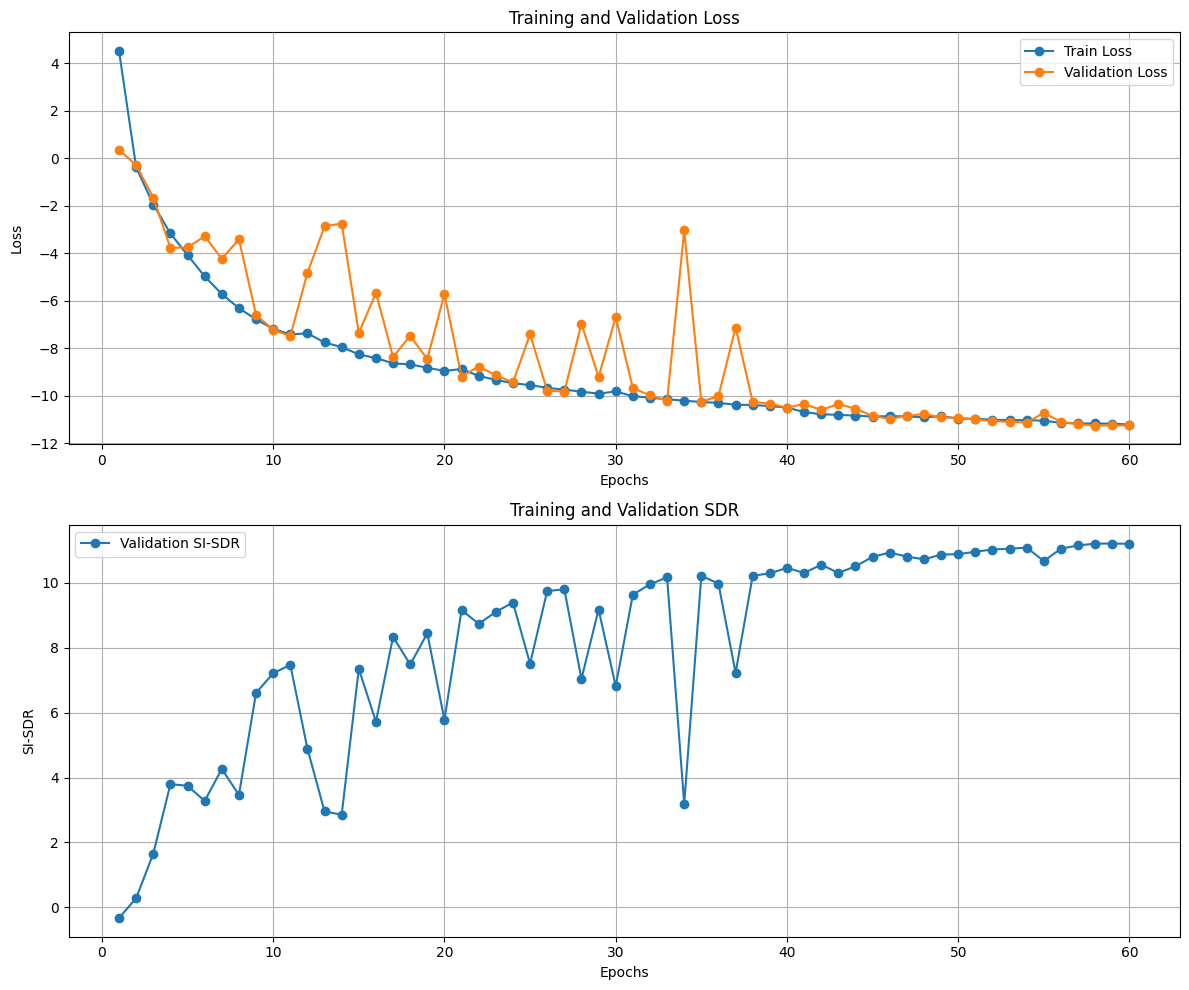

In [43]:
plot_metrics(metrics)

In [44]:
model = best_loss

In [41]:
def evaluate_test(model, test_dataset, device, criterion):
    model.eval()
    SI_SDR_metric = ScaleInvariantSignalDistortionRatio(
        zero_mean=True,  
    ).to(device)
    loss = 0
    si_sdr = 0
    pesq = 0
    with torch.no_grad():
        for batch_x, batch_y in tqdm(test_dataset):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            preds_r, preds_i = model(batch_x.real, batch_x.imag)
            preds = from_sftf(preds_r, preds_i)

            loss += criterion(preds, batch_y)
            si_sdr += SI_SDR_metric(preds, batch_y)
            pesq += calculate_batch_PESQ(preds, batch_y)
    loss /= len(test_dataset)
    si_sdr /= len(test_dataset)
    pesq /= len(test_dataset)
    print(f'Test Loss: {loss}, Test SI-SDR: {si_sdr}, Test PESQ: {pesq}')

In [44]:
def denoise_file(path, model, device, cnt_seconds=16):
    sr = 16000
    noise_arr,_ = librosa.load(path, mono=True, sr=sr, offset=0, duration=16)
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(noise_arr, sr=sr, axis='time')
    plt.title("Noisy Audio")
    plt.tight_layout()
    plt.show()
    display(Audio(noise_arr,rate=sr))

    with torch.no_grad():
        cur_dataset = MyDataset(need_crop=True, cnt_seconds=cnt_seconds, need_all=True, single_file_path=path)

        X = cur_dataset[0][0]
        clear_audio_r, clear_audio_i = model(X.real, X.imag)
        clear_audio = from_sftf(clear_audio_r, clear_audio_i)
        
        clear_audio = clear_audio.detach().cpu().numpy()
        clear_audio = clear_audio.reshape(-1)
    # print(clear_audio.shape)
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(clear_audio, sr=sr, axis='time')
    plt.title("Clear Audio")
    plt.tight_layout()
    plt.show()
    display(Audio(clear_audio,rate=sr))

In [47]:
evaluate_test(model, test_dataset, device, criterion)

100%|██████████| 105/105 [01:10<00:00,  1.50it/s]

Test Loss: -10.727294921875, Test SI-SDR: 10.681081771850586, Test PESQ: 1.6601553407926408


In [59]:
torch.save(model.module.state_dict(), 'model.pt')

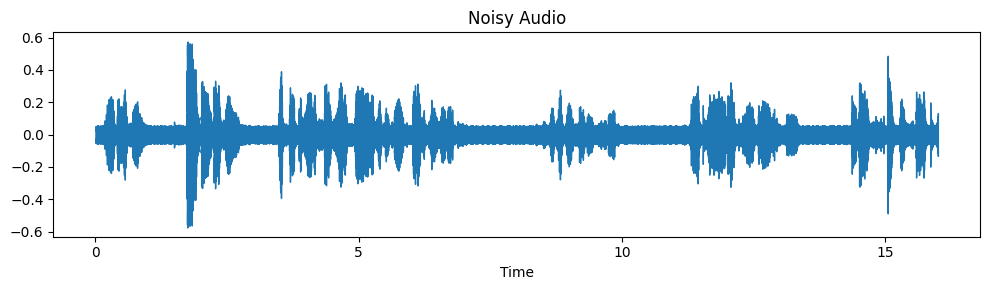

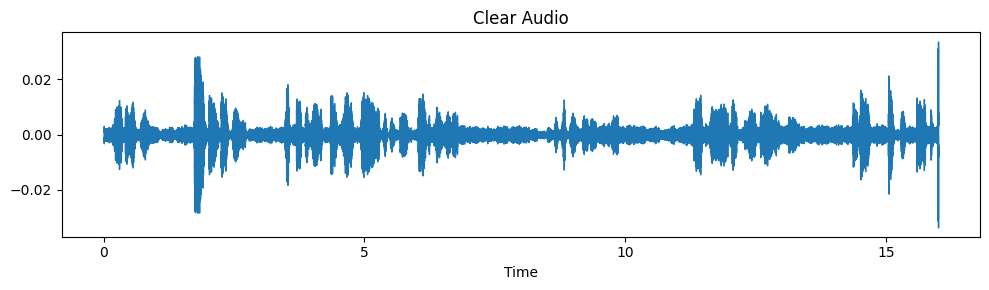

In [45]:
denoise_file('noisy/test/1034-121119-0049.wav', model, device)

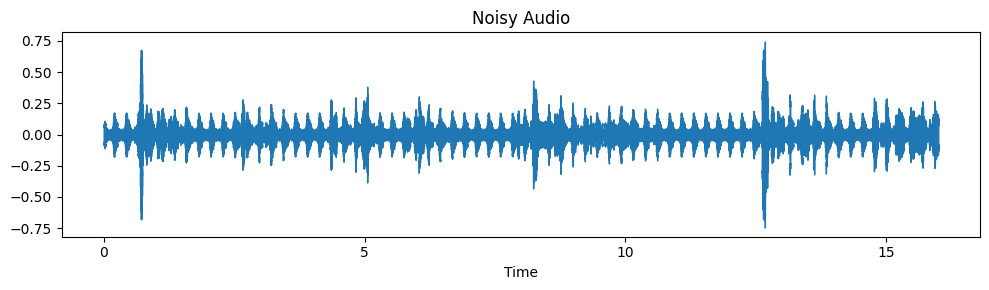

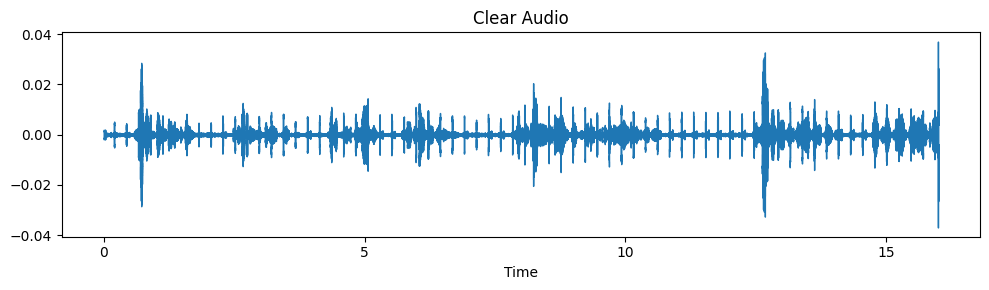

In [46]:
denoise_file('noisy/test/1040-133433-0080.wav', model, device)

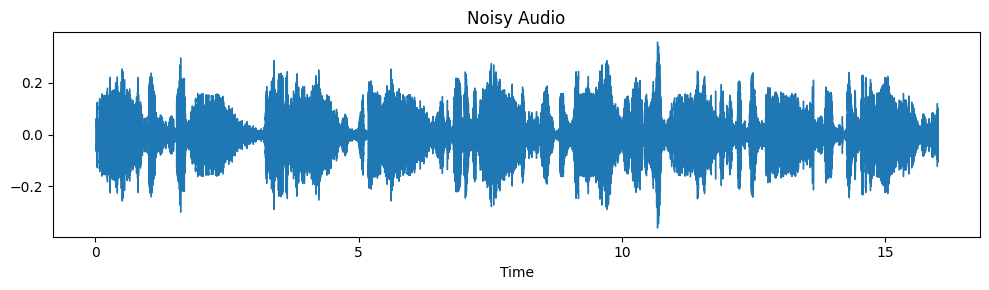

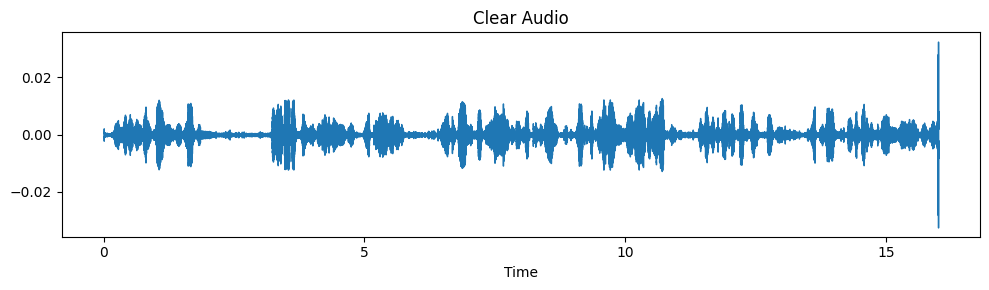

In [47]:
denoise_file('noisy/test/1081-125237-0053.wav', model, device)

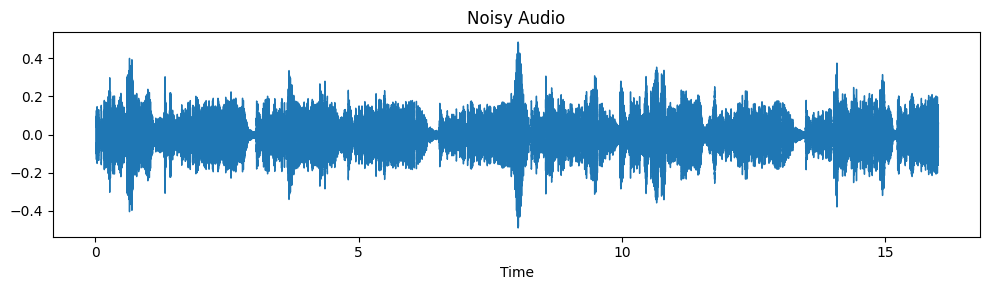

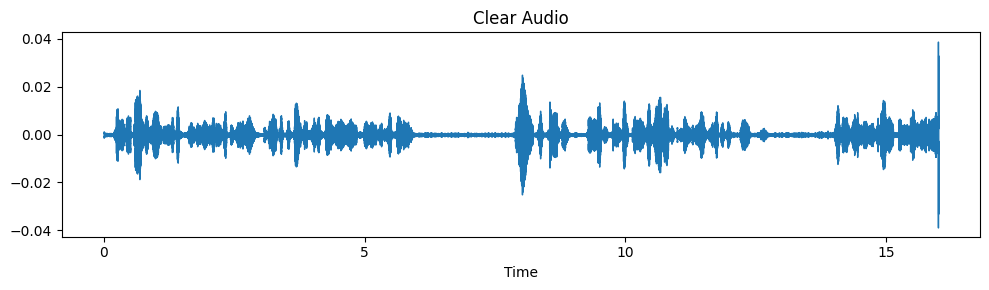

In [48]:
denoise_file('noisy/test/226-131532-0003.wav', model, device)

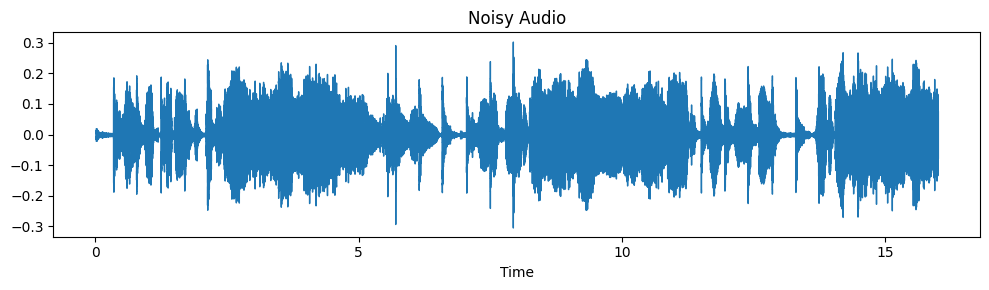

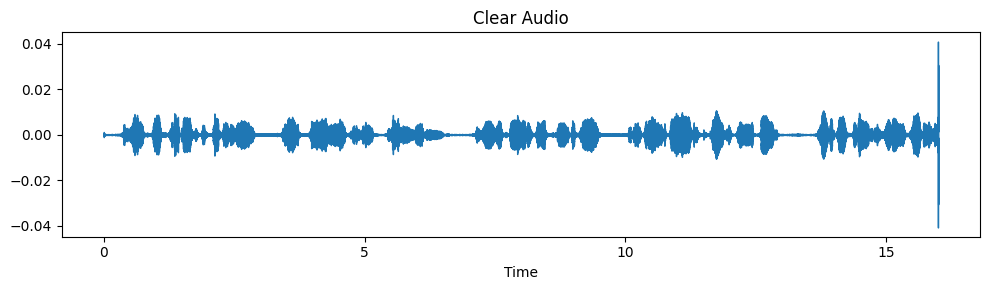

In [50]:
denoise_file('noisy/test/6848-252323-0032.wav', model, device)

In [57]:
!rm -rf denoised libri-noise-dataset.zip noisy samples.7z test.7z train.7z y_test.7z y_train.7z

In [60]:
!ls

model.pt
